#Bonus Project
Topic: Predict The Flight Ticket Price  
Name: Jyoti Dhayal(Roll no: B21EE029)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.utils import shuffle
from torchsummary import summary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

##pre processing

In [ ]:
data = pd.read_csv('/content/Dataset.xlsx - Sheet1.csv')
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
data.shape

(10683, 11)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [ ]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [ ]:
#converting the total duration of flight from hours and minutes format to total duration in minutes format
df=data.copy()

In [ ]:
df['Hours'] = data['Duration'].str.split(' ').str[0]
index=0
'''df['Hours'].fillna(0, inplace=True) '''
for i in df['Hours']:
  index= index+1
  if (i=='5m'):
    print(index)

6475


In [ ]:
duration = list(data['Duration'])
for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())
dur_hours = []
dur_minutes = []
for i in range(len(duration)) :
    dur_hours.append(int(duration[i].split()[0][:-1]))
    dur_minutes.append(int(duration[i].split()[1][:-1]))
data['Duration_hours'] = dur_hours
data['Duration_minutes'] =dur_minutes
data.drop(labels = 'Duration', axis = 1, inplace = True)

In [ ]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration_hours,Duration_minutes
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,non-stop,No info,3897,2,50
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2 stops,No info,7662,7,25
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,2 stops,No info,13882,19,0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1 stop,No info,6218,5,25
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1 stop,No info,13302,4,45


In [ ]:
data['Duration_hours'] = data['Duration_hours'] * 60
df['Duration'] = data['Duration_hours'] + data['Duration_minutes']
df.drop(labels = 'Hours', axis = 1, inplace = True)
data['Duration']=df['Duration']
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,285,1 stop,No info,13302


In [ ]:
data=data.drop(['Duration_hours','Duration_minutes'],axis=1)

In [ ]:
#filling in null values with data from similar flights
null_columns=data.columns[data.isnull().any()]

In [ ]:
print(data[data["Total_Stops"].isnull()][null_columns])

     Route Total_Stops
9039   NaN         NaN


In [ ]:
print(data.loc[[9039]])

        Airline Date_of_Journey Source Destination Route Dep_Time  \
9039  Air India       6/05/2019  Delhi      Cochin   NaN    09:45   

      Arrival_Time Total_Stops Additional_Info  Price  Duration  
9039  09:25 07 May         NaN         No info   7480      1420  


In [ ]:
data.loc[(data.Source=='Delhi') & (data.Destination=='Cochin') & (pd.DatetimeIndex(data['Date_of_Journey']).month==5)& (data.Duration==1420) &(data.Airline=='Air India') ].sort_values(['Date_of_Journey'])

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration
2343,Air India,15/05/2019,Delhi,Cochin,DEL → HYD → MAA → COK,09:45,09:25 16 May,2 stops,No info,10975,1420
2554,Air India,15/05/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 16 May,1 stop,No info,7480,1420
3595,Air India,18/05/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 19 May,1 stop,No info,8372,1420
9717,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → MAA → COK,09:45,09:25 19 May,2 stops,No info,10975,1420
8135,Air India,21/05/2019,Delhi,Cochin,DEL → HYD → MAA → COK,09:45,09:25 22 May,2 stops,No info,10975,1420
1616,Air India,24/05/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 25 May,1 stop,No info,7480,1420


In [ ]:
data.Route=data.Route.fillna('DEL → MAA → COK')
data.loc[data.Total_Stops.isnull(),'Total_Stops']=1

In [ ]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Total_Stops        0
Additional_Info    0
Price              0
Duration           0
dtype: int64

In [ ]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,non-stop,No info,3897,170
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2 stops,No info,7662,445
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,2 stops,No info,13882,1140
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1 stop,No info,6218,325
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1 stop,No info,13302,285


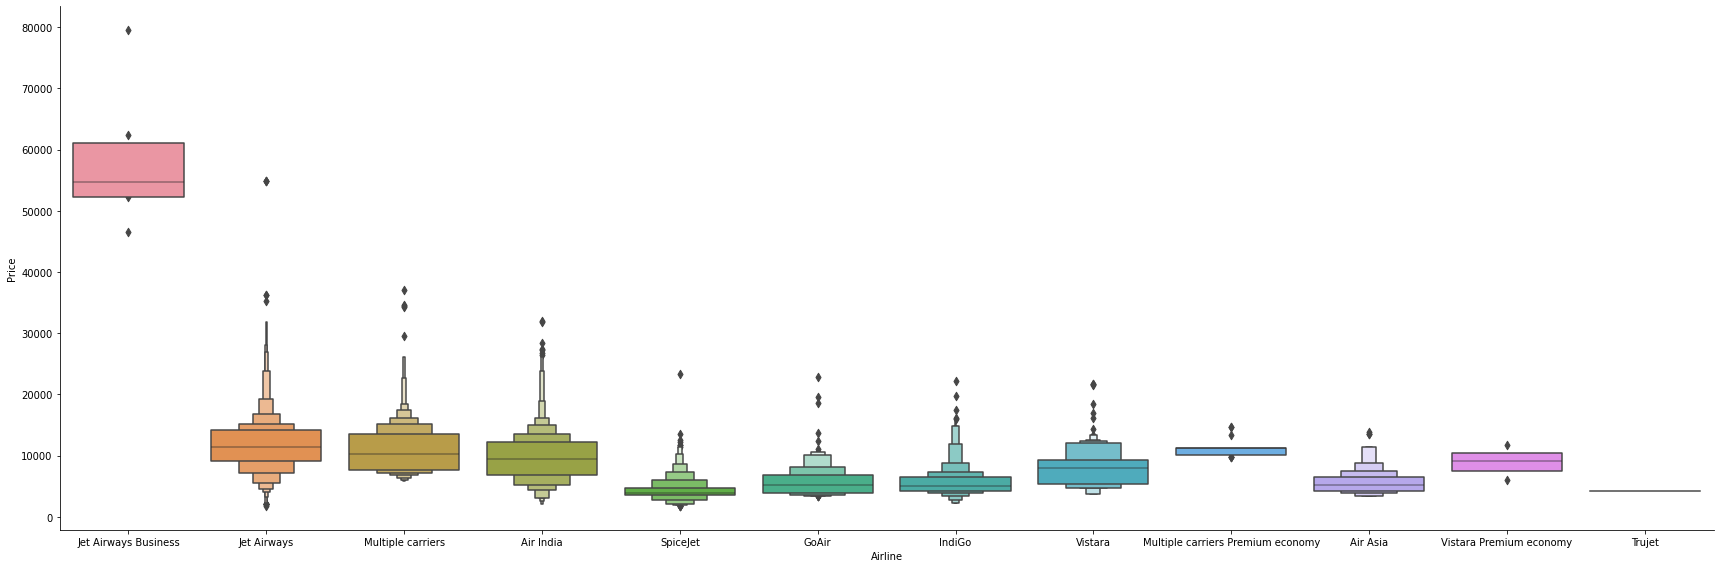

In [ ]:
#airline vs price plot
sns.catplot(y = "Price", x = "Airline", data = data.sort_values("Price", ascending = False), kind="boxen", height = 8, aspect = 3)
plt.show()

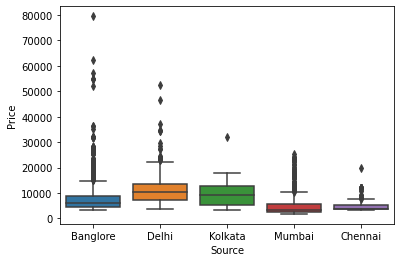

In [ ]:
#source vs price
sns.boxplot(y = "Price", x = "Source", data = data.sort_values("Price", ascending = False))
plt.show()

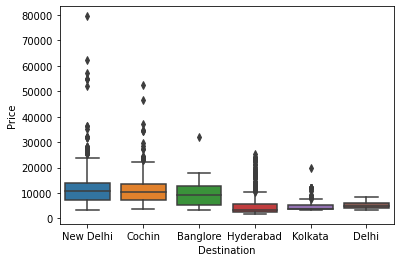

In [ ]:
#destination vs price
sns.boxplot(y = "Price", x = "Destination", data = data.sort_values("Price", ascending = False))
plt.show()

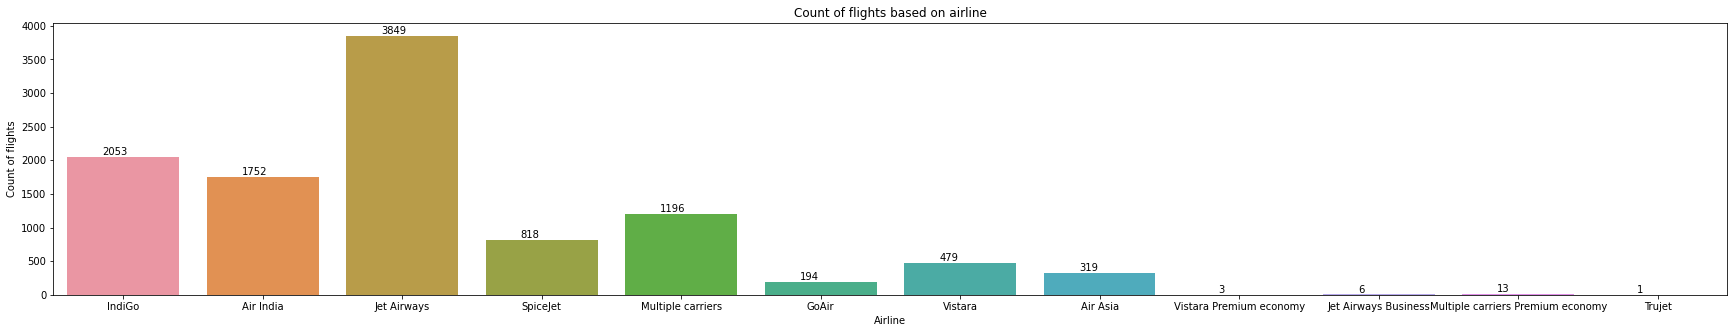

In [ ]:
#Plotting Bar chart for Airline vs Number of Flights
plt.figure(figsize = (30, 5))
plt.title('Count of flights based on airline')
ax=sns.countplot(x = 'Airline', data = data)
plt.xlabel('Airline')
plt.ylabel('Count of flights')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom', color= 'black')

##converting the airlines into different classes of tickets

In [ ]:

data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Total_Stops', 'Additional_Info', 'Price',
       'Duration'],
      dtype='object')

In [ ]:
cols=['Airline','Source','Destination','Route','Total_Stops','Additional_Info']
for i in data[cols]:
    print("Total no of unique keys in", i, data[i].nunique())

Total no of unique keys in Airline 12
Total no of unique keys in Source 5
Total no of unique keys in Destination 6
Total no of unique keys in Route 128
Total no of unique keys in Total_Stops 6
Total no of unique keys in Additional_Info 10


In [ ]:
df=data.copy()

In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,non-stop,No info,3897,170
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2 stops,No info,7662,445
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,2 stops,No info,13882,1140
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1 stop,No info,6218,325
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1 stop,No info,13302,285


In [ ]:
'''df = data[['Airline','Source','Destination','Total_Stops','Additional_Info','Date_of_Journey','Dep_Time','Route','Arrival_Time','Price']]'''

"df = data[['Airline','Source','Destination','Total_Stops','Additional_Info','Date_of_Journey','Dep_Time','Route','Arrival_Time','Price']]"

In [ ]:
df.shape

(10683, 11)

In [ ]:
df.Airline.unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [ ]:
cls = {'IndiGo': 'Economy','GoAir': 'Economy','Vistara': 'Economy','Vistara Premium economy': 'Premium Economy','Air Asia': 'Economy',
         'Trujet': 'Economy','Jet Airways': 'Economy','SpiceJet': 'Economy','Jet Airways Business': 'Business','Air India': 'Economy',
         'Multiple carriers': 'Economy','Multiple carriers Premium economy': 'Premium Economy'}
df['Booking_Class'] = df['Airline'].map(cls)

In [ ]:
df=df.drop(['Airline'],axis=1)

In [ ]:
df.shape

(10683, 11)

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

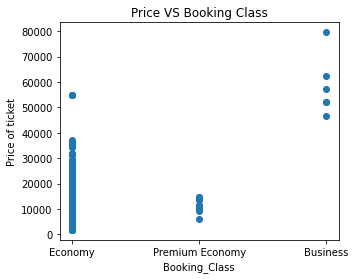

In [ ]:
#plotting class with price
plt.figure(figsize = (5,4))
plt.title('Price VS Booking Class')
plt.scatter(df['Booking_Class'], df['Price'])
plt.xticks
plt.xlabel('Booking_Class')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 0)

##calculating the number of days to departure of the flight

In [ ]:
df1 = df.copy()
df1['Booking_Date'] = '1/1/2019' #data of booking the flight
df1['Booking_Date'] = pd.to_datetime(df1['Booking_Date'],format='%d/%m/%Y')
df1['Date_of_Journey'] = pd.to_datetime(df1['Date_of_Journey'],format='%d/%m/%Y')
df1['Days_to_Departure'] = (df1['Date_of_Journey'] - df1['Booking_Date']).dt.days
df['Days_to_Departure'] = df1['Days_to_Departure']
df1=df1.drop(['Booking_Date','Date_of_Journey'],axis=1)
df1.head()

,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration,Booking_Class,Days_to_Departure
0,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,non-stop,No info,3897,170,Economy,82
1,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2 stops,No info,7662,445,Economy,120
2,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,2 stops,No info,13882,1140,Economy,159
3,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1 stop,No info,6218,325,Economy,131
4,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1 stop,No info,13302,285,Economy,59


In [ ]:
df['Arrival_Time'] = data['Arrival_Time'].str.split(' ').str[0]

In [ ]:
def get_departure(dep):
    dep = dep.split(':')
    dep = int(dep[0])
    if (dep >= 4 and dep < 12):
        return 'Morning'
    elif (dep >= 12 and dep < 18):
        return 'Noon'
    elif (dep >= 18 and dep < 20):
        return 'Evening'
    else:
        return 'Night'

In [ ]:
df['Dep_timeofday'] = data['Dep_Time'].apply(get_departure)
df['Arr_timeofday'] = data['Arrival_Time'].apply(get_departure)

In [ ]:
df.head()

,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration,Booking_Class,Days_to_Departure,Dep_timeofday,Arr_timeofday
0,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,non-stop,No info,3897,170,Economy,82,Night,Night
1,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2 stops,No info,7662,445,Economy,120,Morning,Noon
2,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,2 stops,No info,13882,1140,Economy,159,Morning,Morning
3,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1 stop,No info,6218,325,Economy,131,Evening,Night
4,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1 stop,No info,13302,285,Economy,59,Noon,Night


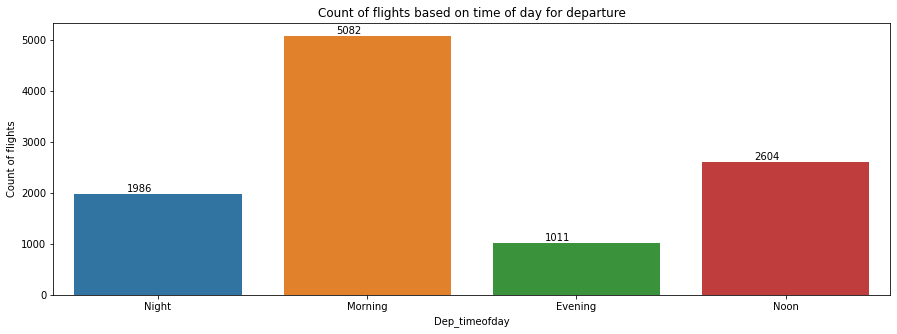

In [ ]:
#Plotting Bar chart for time of day for departure vs Number of Flights
plt.figure(figsize = (15, 5))
plt.title('Count of flights based on time of day for departure')
ax=sns.countplot(x = 'Dep_timeofday', data = df)
plt.xlabel('Dep_timeofday')
plt.ylabel('Count of flights')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom', color= 'black')

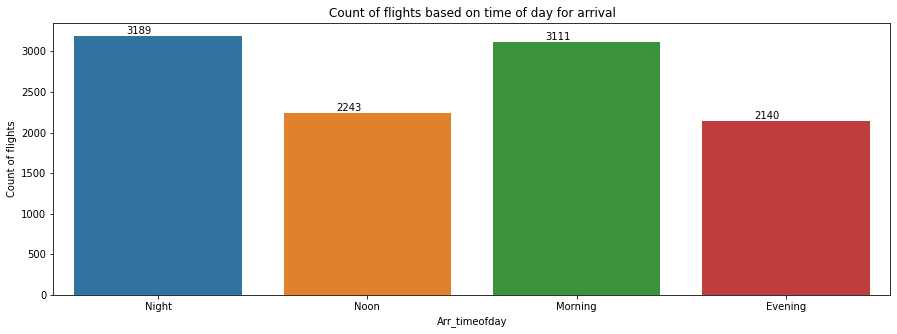

In [ ]:
#Plotting Bar chart for time of day for arrival vs Number of Flights
plt.figure(figsize = (15, 5))
plt.title('Count of flights based on time of day for arrival')
ax=sns.countplot(x = 'Arr_timeofday', data = df)
plt.xlabel('Arr_timeofday')
plt.ylabel('Count of flights')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom', color= 'black')

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

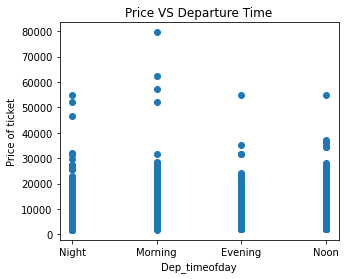

In [ ]:
#plotting departure time with price
plt.figure(figsize = (5,4))
plt.title('Price VS Departure Time')
plt.scatter(df['Dep_timeofday'], df['Price'])
plt.xticks
plt.xlabel('Dep_timeofday')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 0)

##calculating the number of stops of the flight

In [ ]:
df['Total_Stops'] = df['Total_Stops'].str.replace('non-stop','0')
df['Total_Stops'] = df['Total_Stops'].str.replace('stops','')
df['Total_Stops'] = df['Total_Stops'].str.replace('stop','')
df['Total_Stops'].fillna(0, inplace=True)
df['Total_Stops'] = df['Total_Stops'].astype(float)

In [ ]:
df.head()

,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration,Booking_Class,Days_to_Departure,Dep_timeofday,Arr_timeofday
0,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,0.0,No info,3897,170,Economy,82,Night,Night
1,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2.0,No info,7662,445,Economy,120,Morning,Noon
2,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,2.0,No info,13882,1140,Economy,159,Morning,Morning
3,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1.0,No info,6218,325,Economy,131,Evening,Night
4,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1.0,No info,13302,285,Economy,59,Noon,Night


(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <a list of 11 Text major ticklabel objects>)

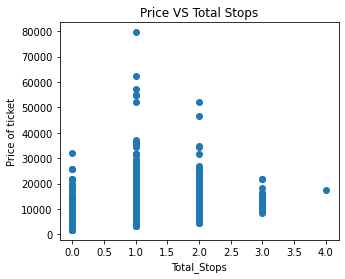

In [ ]:
#plotting total stops with price
plt.figure(figsize = (5,4))
plt.title('Price VS Total Stops')
plt.scatter(df['Total_Stops'], df['Price'])
plt.xticks
plt.xlabel('Total_Stops')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 0)

In [ ]:
df.head()

,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Duration,Booking_Class,Days_to_Departure,Dep_timeofday,Arr_timeofday
0,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,0.0,No info,3897,170,Economy,82,Night,Night
1,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2.0,No info,7662,445,Economy,120,Morning,Noon
2,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,2.0,No info,13882,1140,Economy,159,Morning,Morning
3,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1.0,No info,6218,325,Economy,131,Evening,Night
4,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1.0,No info,13302,285,Economy,59,Noon,Night


In [ ]:
df = pd.get_dummies(df, columns=['Source', 'Destination', 'Additional_Info', 'Date_of_Journey','Dep_Time', 'Arrival_Time', 'Dep_timeofday', 'Booking_Class', 'Arr_timeofday'],drop_first=True)

In [ ]:
df.head()

,Route,Total_Stops,Price,Duration,Days_to_Departure,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,...,Arrival_Time_23:50,Arrival_Time_23:55,Dep_timeofday_Morning,Dep_timeofday_Night,Dep_timeofday_Noon,Booking_Class_Economy,Booking_Class_Premium Economy,Arr_timeofday_Morning,Arr_timeofday_Night,Arr_timeofday_Noon
0,BLR → DEL,0.0,3897,170,82,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,CCU → IXR → BBI → BLR,2.0,7662,445,120,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
2,DEL → LKO → BOM → COK,2.0,13882,1140,159,0,1,0,0,1,...,0,0,1,0,0,1,0,1,0,0
3,CCU → NAG → BLR,1.0,6218,325,131,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,BLR → NAG → DEL,1.0,13302,285,59,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0


##figuring out the route for the flights

In [ ]:
def clean_route(route):
    route = str(route)
    route = route.split(' → ')
    return ' '.join(route)

df['Route'] = df['Route'].apply(clean_route)


tf = TfidfVectorizer(ngram_range=(1, 1), lowercase=False)
route = tf.fit_transform(df['Route'])

route = pd.DataFrame(data = route.toarray(), columns=tf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
route

,AMD,ATQ,BBI,BDQ,BHO,BLR,BOM,CCU,COK,DED,...,NDC,PAT,PNQ,RPR,STV,TRV,UDR,VGA,VNS,VTZ
0,0.0,0.0,0.000000,0.0,0.0,0.783042,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.619874,0.0,0.0,0.194833,0.000000,0.248235,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.241497,0.000000,0.271815,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.274089,0.000000,0.349214,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.284916,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0.0,0.0,0.000000,0.0,0.0,0.617413,0.000000,0.786639,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10679,0.0,0.0,0.000000,0.0,0.0,0.617413,0.000000,0.786639,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10680,0.0,0.0,0.000000,0.0,0.0,0.783042,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10681,0.0,0.0,0.000000,0.0,0.0,0.783042,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = pd.concat([df, route], axis=1)
df.drop('Route', axis=1, inplace=True)

In [ ]:
df

,Total_Stops,Price,Duration,Days_to_Departure,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,...,NDC,PAT,PNQ,RPR,STV,TRV,UDR,VGA,VNS,VTZ
0,0.0,3897,170,82,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,7662,445,120,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,13882,1140,159,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,6218,325,131,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,13302,285,59,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0.0,4107,150,98,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10679,0.0,4145,155,116,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10680,0.0,7229,180,116,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10681,0.0,12648,160,59,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##dividing the data into train and test sets, for implementing th emodels

In [ ]:
df.shape

(10683, 558)

In [ ]:
X = df.drop(labels=['Price'], axis=1)
y = df['Price'].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
X = pd.DataFrame(scaled)
y = np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
X_train.shape

(7478, 557)

In [ ]:
y_train.shape

(7478,)

In [ ]:
X_test.shape

(3205, 557)

In [ ]:
y_test.shape

(3205,)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,547,548,549,550,551,552,553,554,555,556
4551,0.00,0.052539,0.559322,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7226,0.25,0.514886,0.169492,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6202,0.25,0.313485,0.898305,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4235,0.25,0.187391,0.847458,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9664,0.25,0.332750,0.847458,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0.25,0.309982,0.847458,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7813,0.00,0.050788,0.457627,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
905,0.25,0.157618,0.661017,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5192,0.25,0.506130,0.610169,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##implementing the models

Testing on different ML models:

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

##1. LGBM


In [ ]:
param = {'objective': 'regression','boosting': 'gbdt','num_iterations': 3000,'learning_rate': 0.06,'num_leaves': 40,'max_depth': 24,'min_data_in_leaf':11,
         'max_bin': 4,'metric': 'l2_root'}
lgbm = lgb.train(params=param,verbose_eval=1000,train_set=train_data,valid_sets=[test_data])
y_pred1 = lgbm.predict(X_test)
print("Test Results for LGBM Regressor :")
le1 = sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred1)))
mse1 = sqrt(mse(y_test, y_pred1))
r2_1 = r2_score(y_test, y_pred1)
print("Mean squared error log error : ", le1)
print("Root mean squared error : ", mse1)
print("R2 Score : ", r2_1)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	valid_0's rmse: 0.133906
[2000]	valid_0's rmse: 0.136101
[3000]	valid_0's rmse: 0.138071
Test Results for LGBM Regressor :
Mean squared error log error :  0.13805169098571862
Root mean squared error :  0.13807106869792152
R2 Score :  0.9286134786226787


##2. XGBM

In [ ]:
xgb = XGBRegressor(max_depth=9,learning_rate=0.5,n_estimators=112,silent=False,objective='reg:linear',booster='gbtree',n_jobs=1,nthread=None,
                   gamma=0,min_child_weight=1,max_delta_step=0,subsample=1,colsample_bytree=1,colsample_bylevel=1,reg_alpha=1,reg_lambda=1,
                   scale_pos_weight=1,base_score=0.5,random_state=0,seed=None)

xgb.fit(X_train, y_train)
y_pred2 = xgb.predict(X_test)
print("Test Results for XGBoost Regressor :")
le2 = sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred2)))
mse2 = sqrt(mse(y_test, y_pred2))
r2_2 = r2_score(y_test, y_pred2)
print("Mean squared error log error : ", le2)
print("Root mean squared error : ", mse2)
print("R2 Score : ", r2_2)

[12:10:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test Results for XGBoost Regressor :
Mean squared error log error :  0.13716860971040323
Root mean squared error :  0.13718817481344786
R2 Score :  0.9295235202688654


##3.Bagging Regressor

In [ ]:
br = BaggingRegressor(base_estimator=None,n_estimators=50,max_samples=1.0,max_features=1.0,bootstrap=True,bootstrap_features=False,oob_score=False,
                      warm_start=False,n_jobs=1,random_state=1,verbose=0)
br.fit(X_train, y_train)
y_pred3 = br.predict(X_test)
print("Test Results for Bagging Regressor :")
le3 = sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred3)))
mse3 = sqrt(mse(y_test, y_pred3))
r2_3 = r2_score(y_test, y_pred3)
print("Mean squared error log error : ", le3)
print("Root mean squared error : ", mse3)
print("R2 Score : ", r2_3)

Test Results for Bagging Regressor :
Mean squared error log error :  0.13963848632597461
Root mean squared error :  0.13965757854663144
R2 Score :  0.9269635152706424


##4.Gradient Boosting Regressor

In [ ]:
gb = GradientBoostingRegressor(loss='ls',learning_rate=0.3,subsample=1.0,criterion='friedman_mse',min_samples_split=30,min_samples_leaf=1,
                               min_weight_fraction_leaf=0.0,max_depth=7,min_impurity_decrease=0.0,init=None,random_state=0,max_features=None,alpha=0.9,
                               verbose=100,max_leaf_nodes=None,warm_start=False)
gb.fit(X_train, y_train)
y_pred4 = gb.predict(X_test)
print("Test Results for Gradient Boosting Regressor :")
le4 = sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred4)))
mse4 = sqrt(mse(y_test, y_pred4))
r2_4 = r2_score(y_test, y_pred4)
print("Mean squared error log error : ", le4)
print("Root mean squared error : ", mse4)
print("R2 Score : ", r2_4)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


      Iter       Train Loss   Remaining Time 
         1           0.1510           13.07s
         2           0.0937           12.66s
         3           0.0642           13.15s
         4           0.0483           13.11s
         5           0.0387           13.12s
         6           0.0333           13.08s
         7           0.0295           12.87s
         8           0.0277           12.90s
         9           0.0265           12.84s
        10           0.0253           13.16s
        11           0.0244           13.00s
        12           0.0236           13.08s
        13           0.0231           12.99s
        14           0.0228           12.95s
        15           0.0224           12.85s
        16           0.0219           12.84s
        17           0.0212           12.71s
        18           0.0209           12.64s
        19           0.0207           12.59s
        20           0.0204           12.47s
        21           0.0202           12.31s
        2

##Comparing the models

In [ ]:
Models = ['LGBM Regressor','XGBoost Regressor','Bagging Regressor','Gradient Boosting Regressor' ]
mse = [mse1, mse2, mse3, mse4]
r2 = [r2_1, r2_2, r2_3, r2_4]
le = [le1, le2, le3, le4]

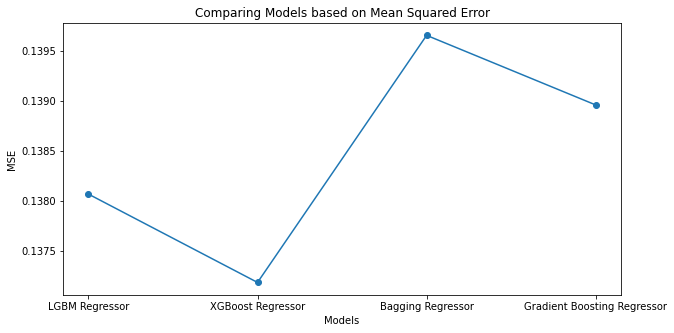

In [ ]:
plt.figure(figsize = (10, 5))
plt.title('Comparing Models based on Mean Squared Error')
ax = plt.scatter(x = Models, y = mse)
plt.xlabel('Models')
plt.ylabel('MSE')
plt.plot( Models,  mse)

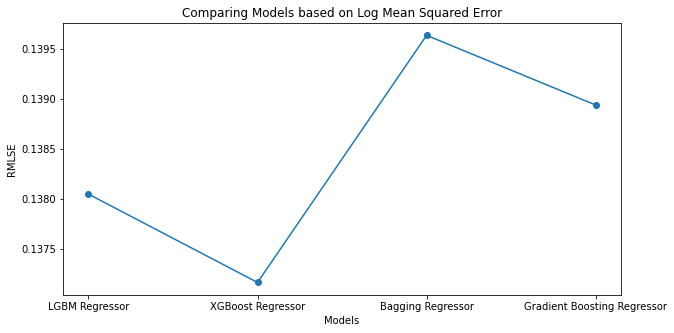

In [ ]:
plt.figure(figsize = (10, 5))
plt.title('Comparing Models based on Log Mean Squared Error')
ax = plt.scatter(x = Models, y = le)
plt.xlabel('Models')
plt.ylabel('RMLSE')
plt.plot( Models,  le)

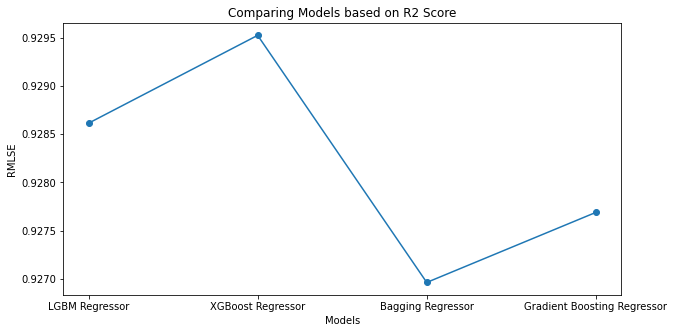

In [ ]:
plt.figure(figsize = (10, 5))
plt.title('Comparing Models based on R2 Score')
ax = plt.scatter(x = Models, y = r2)
plt.xlabel('Models')
plt.ylabel('RMLSE')
plt.plot( Models,  r2)

In [ ]:
Predicted_price = y_pred1*0.15 + y_pred2*0.50 + y_pred3*0.15 + y_pred4*0.20
y_pred = np.exp(Predicted_price)

In [ ]:
prediction=pd.DataFrame(y_pred,columns=['Predicted Price'])

In [ ]:
prediction

,Predicted Price
0,2521.519875
1,5848.367353
2,13908.733428
3,14192.398127
4,10785.804308
...,...
3200,7585.785644
3201,8469.660661
3202,3951.584743
3203,9618.342731


In [ ]:
prediction.to_csv("predicted.csv",index=None)